In [4]:
# extension: multi-class logistic regression
# base algorithm: binary logistic regression

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [5]:
# data reading and preprocessing
# since we are dealing with categorical features, we translate them to integer labels.
# we can do this without headaches since we are not running any actual regression on our data.

df = pd.read_csv('../datasets/wine.csv', header=None, names = ["label", "alcohol","malic acid","ash", "alcalinity of ash", 
                                                   "magnesium", "total phenols", "flavanoids",
                                                   "nonflavanoid phenols", "proanthocyanins", "color intensity",
                                                   "hue", "OD280/OD315 of diluted wines", "proline"])

df.head()

,label,alcohol,malic acid,ash,alcalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD280/OD315 of diluted wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
names = ["alcohol","malic acid","ash", "alcalinity of ash", 
         "magnesium", "total phenols", "flavanoids",
         "nonflavanoid phenols", "proanthocyanins", "color intensity",
         "hue", "OD280/OD315 of diluted wines", "proline"]

df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df[names],df['label'], random_state=2435234)


X_train=df_X_train.to_numpy()
X_test=df_X_test.to_numpy()
y_train=df_y_train.to_numpy()
y_test=df_y_test.to_numpy()


scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# prepending training samples with 1
ones = np.ones(X_train.shape[0]).reshape((X_train.shape[0], 1))
X_train = np.hstack((ones, X_train))


# prepending test samples with 1
ones = np.ones(X_test.shape[0]).reshape((X_test.shape[0], 1))
X_test = np.hstack((ones, X_test))

In [7]:
# softmax function for extension

def softmax(z):
    e_z = np.exp(np.array(z))
    return e_z / np.sum(e_z, axis = 0)

In [8]:
# intializing parameters w_i for extension; denoted W

features = X_train.shape[1]
classes = 3                                # three classes according to dataset

W = np.zeros((classes, features))

In [9]:
# hypothesis function for multiclass

def multi_hypothesis(X, W):
    if X.ndim == 1:
        return softmax(np.matmul(W, X))
    else:
        result = []
        for i in range(0, X.shape[0]):
            result.append(softmax(np.matmul(W, X[i])))
        return np.array(result)

In [10]:
# categorical cross_entropy

def cat_x_entropy(X , y , W):
    log_likelihood = 0
    h = multi_hypothesis(X, W)
    
    for i in range(0, X.shape[0]):
        val = -1 * np.log(h[i][y[i]-1])
        log_likelihood += val
    return -1*log_likelihood / X.shape[0]

In [11]:
def one_hot_encode(label, classes):
    vec = np.zeros(classes)
    vec[label - 1] = 1
    return vec

In [12]:
# modified gradient ascent

features = X_train.shape[1]
classes = 3 

def multi_gradient_ascent(X, y, learning_rate, num_iters):
    entropy_values = []
    W = np.zeros((classes, features))
    N = X.shape[0] 
  
    for i in range(0, num_iters):
        h_current = multi_hypothesis(X, W)
        for j in range(0, W.shape[0]):
            gradient_term = np.zeros((W.shape[1], ))
            for l in range(0, X.shape[0]):
                y_n = one_hot_encode(y[l], classes)
                gradient_term += np.multiply(y_n[j] - h_current[l][j], X[l])                
            W[j] += (learning_rate/N)*gradient_term 
            
        if (i % 100) == 0:
            entropy_values.append([i, cat_x_entropy(X,y,W)])
        
    return W, entropy_values

In [13]:
# fitting our model

learning_rate = 0.25
num_iters = 2000      # The number of iterations to run the gradient ascent algorithm

W, entropy_values = multi_gradient_ascent(X_train, y_train, learning_rate, num_iters)
print(W)

[[ 0.37582874  1.34856126  0.33368576  0.94976528 -1.61363153  0.11834935
   0.55401524  1.0777676  -0.11753371 -0.06018848  0.09566429  0.12027834
   0.99276151  1.70810654]
 [ 0.47480413 -2.02325426 -0.57554064 -1.74324623  1.37723292 -0.27134544
  -0.47182437  0.55048141  0.25580044  0.6303248  -1.61297529  1.26050208
   0.29143598 -2.23124107]
 [-0.85063287  0.674693    0.24185488  0.79348095  0.23639861  0.15299609
  -0.08219087 -1.62824901 -0.13826674 -0.57013632  1.517311   -1.38078042
  -1.28419749  0.52313453]]


In [14]:
# measuring accuracy

correct = 0

for i in range(0, X_test.shape[0]):
    hyp = multi_hypothesis(X_test[i], W)
    if np.argmax(hyp) == y_test[i]-1:
        correct += 1

print("my accuracy: ", correct / X_test.shape[0])

my accuracy:  0.9777777777777777


In [15]:
# measuring accuracy of scikit's implementation

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train, y_train)

acc = clf.score(X_test, y_test)
print("scikit accuracy: ", acc)

scikit accuracy:  0.9777777777777777


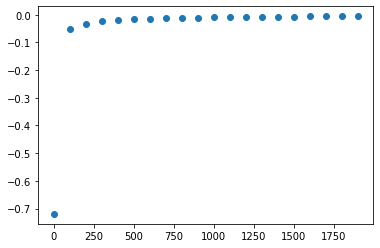

In [16]:
plt.scatter(*zip(*entropy_values))